# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1(n_components=50):
    # Run PCA on train_data for first 50 components
    pca = PCA(n_components=n_components)
    pca.fit(train_data)
    
    # Output cumulative ratios
    print("Fraction of total variance from %i components: %s" % (n_components, str(sum(pca.explained_variance_ratio_))))
    
    
P1(50)

Fraction of total variance from 50 components: 0.9821028291676887


(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

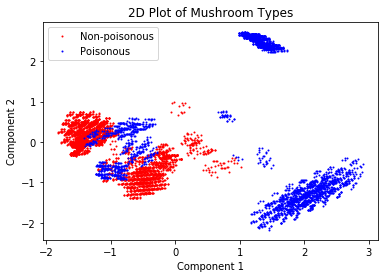

In [5]:
def P2():
    # Project training data down to 2 dimensions
    pca = PCA(n_components=2).fit(train_data)
    d2_data = pca.transform(train_data)
    
    # Seperate data by train_label
    poisonous_data = d2_data[train_labels[:] == 1]
    nonpoisonous_data = d2_data[train_labels[:] == 0]
    
    # Plot poisonous vs non-poisonous datapoints
    plt.plot(nonpoisonous_data[:, 0], nonpoisonous_data[:, 1], "or", markersize=1)
    plt.plot(poisonous_data[:, 0], poisonous_data[:, 1], "ob", markersize=1)
    plt.legend(('Non-poisonous','Poisonous'))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("2D Plot of Mushroom Types")
    
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

c:\software\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
c:\software\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
c:\software\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes usi

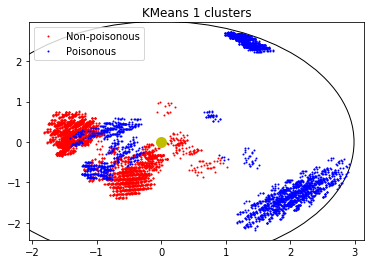

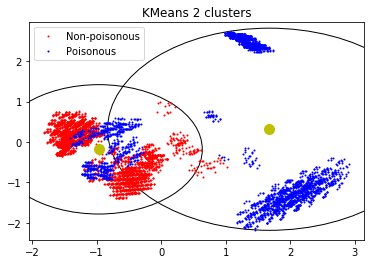

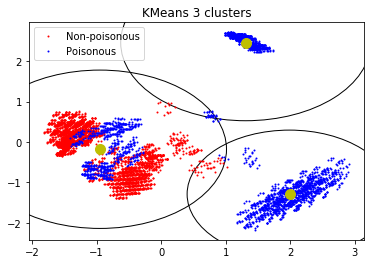

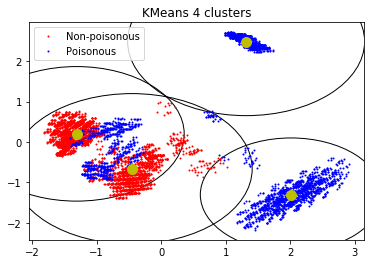

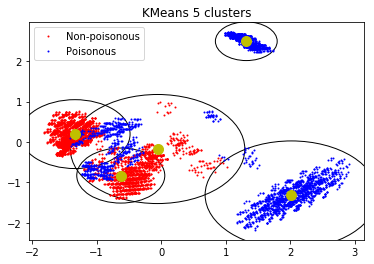

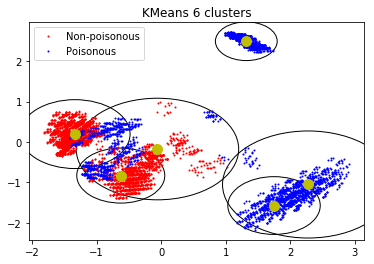

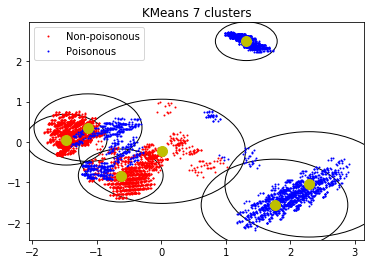

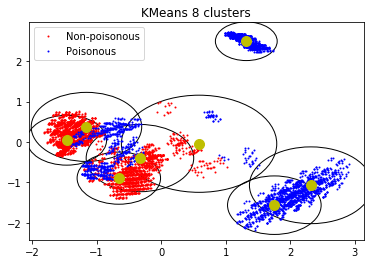

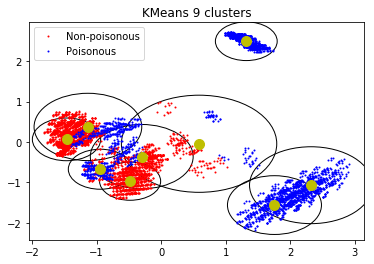

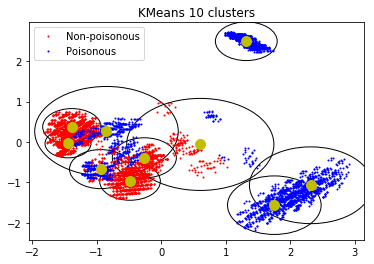

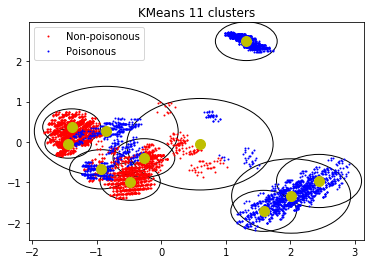

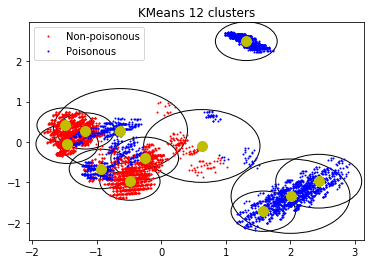

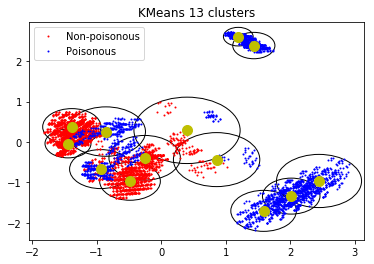

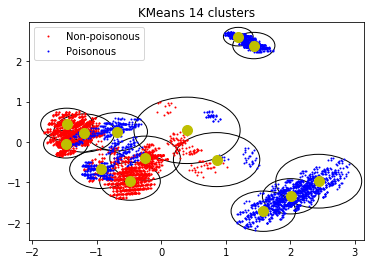

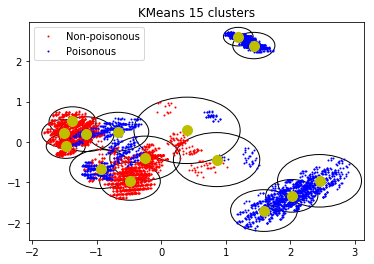

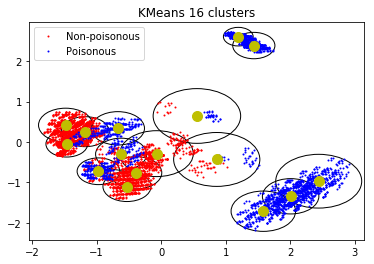

In [6]:
def P3():
    # Project training data down to 2 dimensions
    pca = PCA(n_components=2).fit(train_data)
    d2_data = pca.transform(train_data)

    # Seperate data by train_label
    poisonous_data = d2_data[train_labels[:] == 1]
    nonpoisonous_data = d2_data[train_labels[:] == 0]
        
    for n_clusters in range(1,17):
        # Fit KMeans cluster
        kmeans = KMeans(n_clusters=n_clusters)
        distances = kmeans.fit_transform(d2_data)
        
        # Plot KMeans cluster
        plt.figure(n_clusters)
        plt.title("KMeans %i clusters" % n_clusters)
        new_plot = plt.subplot(1, 1, 1)
        new_plot.plot(nonpoisonous_data[:, 0], nonpoisonous_data[:, 1], "or", markersize=1)
        new_plot.plot(poisonous_data[:, 0], poisonous_data[:, 1], "ob", markersize=1)
        new_plot.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], "oy", markersize=10)
        new_plot.legend(('Non-poisonous','Poisonous'))

        # Add circle to most distant point assigned for a cluster
        data_len = range(distances.shape[0])
        num_clusters = range(distances.shape[1])
        
        for c in num_clusters:
            # Get cluster distances for the current cluster
            curr_cluster_distances = distances[:, c]
            
            # Get datapoints which are predicted to be in the current cluster
            curr_cluster_assigned_distances = curr_cluster_distances[kmeans.labels_ == c]
            
            # Find the max datapoint
            max_distance = max(curr_cluster_assigned_distances)

            # Plot circle with radius of max_distance around current cluster's centroid
            circle = plt.Circle((kmeans.cluster_centers_[c,0], kmeans.cluster_centers_[c,1]), max_distance, Fill=False)
            plt.gca().add_artist(circle)

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

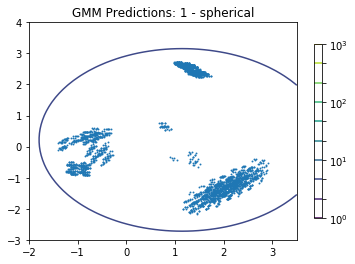

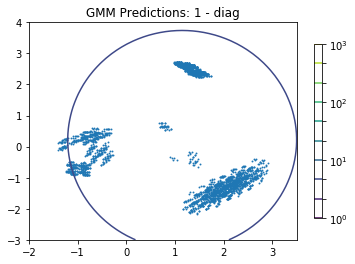

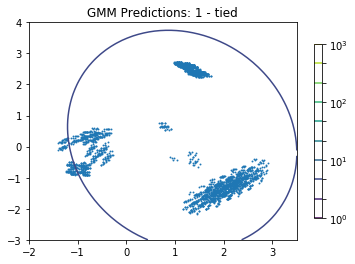

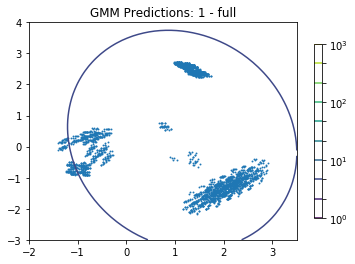

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


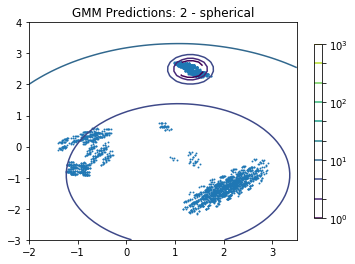

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


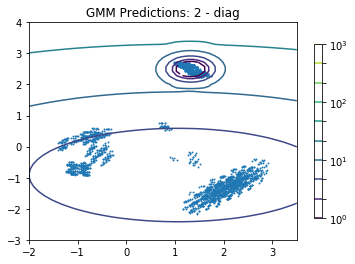

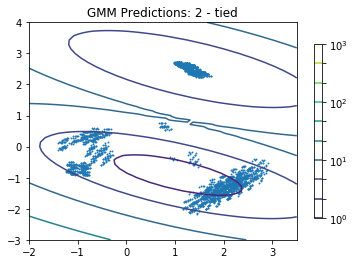

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


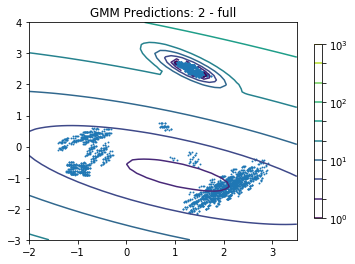

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


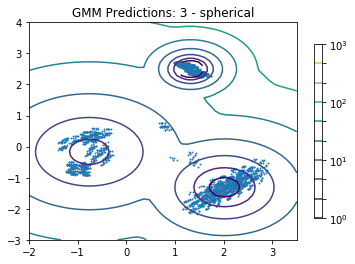

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


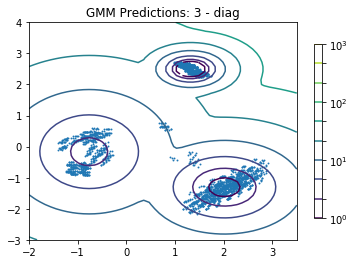

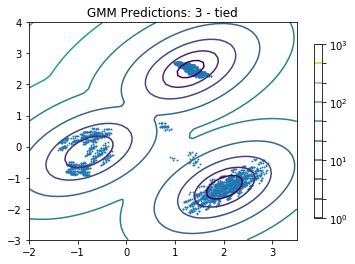

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


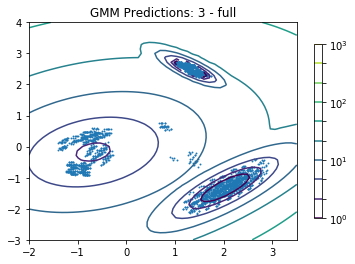

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


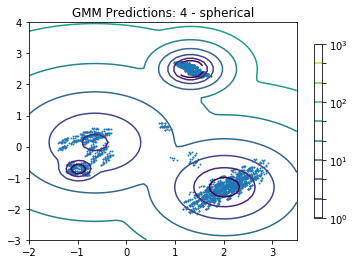

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


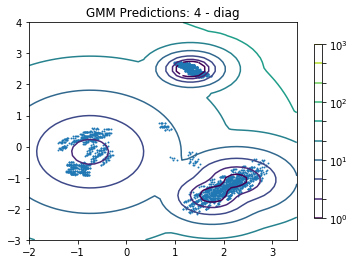

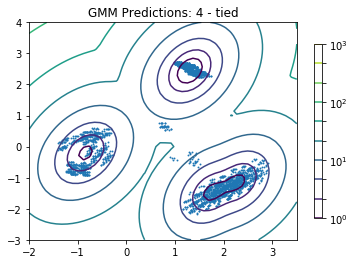

c:\software\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


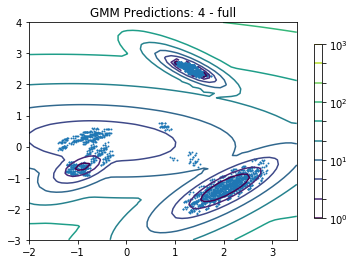

In [7]:
def P4():
    # Project training data down to 2 dimensions
    pca = PCA(n_components=2).fit(train_data)
    d2_data = pca.transform(train_data)

    # Get positive/poisonous datapoints
    poisonous_data = d2_data[train_labels[:] == 1]
    
    for num_component in range(1, 5):
        for cov_type in ['spherical', 'diag', 'tied', 'full']:
            # Fit GMM
            gmm = GaussianMixture(n_components=num_component, covariance_type=cov_type)
            gmm.fit(poisonous_data)

            # Plot estimated density contours using example code from the reference link
            x = np.linspace(-2., 3.5)
            y = np.linspace(-3., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(poisonous_data[:, 0], poisonous_data[:, 1], .8)

            plt.title('GMM Predictions: %i - %s' % (num_component, cov_type))
            plt.axis('tight')
            plt.show()
    
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
    # Project training data down to 2 dimensions
    pca = PCA(n_components=2).fit(train_data)
    d2_data = pca.transform(train_data)

    # Get positive/poisonous datapoints
    poisonous_data = d2_data[train_labels[:] == 1]
    nonpoisonous_data = d2_data[train_labels[:] == 0]
    
    # Fit GMMs
    nonp_gmm = GaussianMixture(n_components=4, covariance_type='full')
    nonp_gmm.fit(nonpoisonous_data, [0 for i in nonpoisonous_data])
    
    p_gmm = GaussianMixture(n_components=4, covariance_type='full')
    p_gmm.fit(poisonous_data, [1 for i in nonpoisonous_data])
    
    # Score GMMs
    # Calculate probabilities
    d2_test_data = pca.transform(test_data)
    nonpoisonous_probs = np.exp(nonp_gmm.score_samples(d2_test_data))
    poisonous_probs = np.exp(p_gmm.score_samples(d2_test_data))
    
    # Predict based upon probabilities
    predictions = []
    for i in range(len(test_labels)):
        predictions.append(1 if poisonous_probs[i] >= nonpoisonous_probs[i] else 0)

    # Calculate accuracy
    test_accuracy = np.mean(predictions == test_labels) * 100
    print("GMM Accuracy: " + str(test_accuracy))
    
    
P5()

GMM Accuracy: 95.01779359430606


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def P6():
    best_accuracy_hash = {'accuracy': 0.0, 'pca_comp': 0, 'gmm_comp': 0, 'cov_type': '', 'param_count': 0}
    
    for pca_component in range(1, 7):
        for gmm_component in range(1, 7):
            for cov_type in ['spherical', 'diag', 'tied', 'full']:
                # Project training data down to 2 dimensions
                pca = PCA(n_components=pca_component).fit(train_data)
                pca_data = pca.transform(train_data)

                # Get positive/poisonous datapoints
                poisonous_data = pca_data[train_labels[:] == 1]
                nonpoisonous_data = pca_data[train_labels[:] == 0]

                # Fit GMMs
                nonp_gmm = GaussianMixture(n_components=gmm_component, covariance_type=cov_type)
                nonp_gmm.fit(nonpoisonous_data, [0 for i in nonpoisonous_data])

                p_gmm = GaussianMixture(n_components=gmm_component, covariance_type=cov_type)
                p_gmm.fit(poisonous_data, [1 for i in nonpoisonous_data])

                # Score GMMs
                # Calculate probabilities
                pca_test_data = pca.transform(test_data)
                nonpoisonous_probs = np.exp(nonp_gmm.score_samples(pca_test_data))
                poisonous_probs = np.exp(p_gmm.score_samples(pca_test_data))

                # Predict based upon probabilities
                predictions = []
                for i in range(len(test_labels)):
                    predictions.append(1 if poisonous_probs[i] >= nonpoisonous_probs[i] else 0)

                # Calculate accuracy
                test_accuracy = np.mean(predictions == test_labels) * 100

                # Parameter count calculation based upon example from Task 6 description...
                cov_type_matrix_count = 1 if cov_type == 'tied' else gmm_component
                parameter_count = (pca_component + cov_type_matrix_count) * gmm_component * 2
                
                # Calculate best accuracy if parameter count is <= 50
                if parameter_count <= 50 and test_accuracy > best_accuracy_hash['accuracy']:
                    best_accuracy_hash = {'accuracy': test_accuracy, 
                                          'pca_comp': pca_component, 
                                          'gmm_comp': gmm_component,
                                          'cov_type': cov_type,
                                          'param_count': parameter_count}
                    print("New Best Accuracy: %s" % str(test_accuracy))

    print("\nBest Model Parameters")
    print("Accuracy: %s, PCA Comps: %i, GMM Comps: %i, Cov Type: %s, Param Count: %i" % 
              (str(best_accuracy_hash['accuracy']), 
               best_accuracy_hash['pca_comp'], 
               best_accuracy_hash['gmm_comp'], 
               best_accuracy_hash['cov_type'],
               best_accuracy_hash['param_count']))

    
P6()

New Best Accuracy: 84.4306049822064
New Best Accuracy: 89.85765124555161
New Best Accuracy: 90.65836298932385
New Best Accuracy: 90.92526690391459
New Best Accuracy: 91.54804270462633
New Best Accuracy: 91.81494661921708
New Best Accuracy: 93.32740213523132
New Best Accuracy: 93.59430604982207
New Best Accuracy: 94.57295373665481
New Best Accuracy: 95.2846975088968
New Best Accuracy: 96.97508896797153
New Best Accuracy: 97.15302491103202
New Best Accuracy: 97.59786476868328
New Best Accuracy: 98.93238434163702

Best Model Parameters
Accuracy: 98.93238434163702, PCA Comps: 5, GMM Comps: 3, Cov Type: full, Param Count: 48
